# Device Helper: Graph RAG

Reference: https://colab.research.google.com/drive/1_AK-CHELz0fLAc2RCPvPgD-R7-NGyrGu#scrollTo=bGBJEDKKjRu9


In [1]:
!pip install kuzu scipy networkx pandas
!pip install matplotlib ipywidgets yfiles-jupyter-graphs

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.9/6.9 MB 15.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 15.7/15.7 MB 23.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 22.9 MB/s eta 0:00:00


# Synthetic Data Generation

### Generate the Graph

**Graph without Node description**

In [2]:
# https://github.com/abhi1nandy2/EMNLP-2021-Findings/blob/main/data/s10_50_questions.csv
# Create A graph Based from CSV

! wget https://raw.githubusercontent.com/abhi1nandy2/EMNLP-2021-Findings/refs/heads/main/data/s10_50_questions.csv

--2025-04-24 10:43:45--  https://raw.githubusercontent.com/abhi1nandy2/EMNLP-2021-Findings/refs/heads/main/data/s10_50_questions.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 25114 (25K) [text/plain]
Saving to: ‘s10_50_questions.csv’

s10_50_questions.cs 100%[===================>]  24.53K  --.-KB/s    in 0.001s  

2025-04-24 10:43:45 (16.7 MB/s) - ‘s10_50_questions.csv’ saved [25114/25114]



In [3]:
import kuzu
import pandas as pd
import networkx as nx

In [4]:
s10_file = 's10_50_questions.csv'
s10 = pd.read_csv(s10_file)
s10.head()

,question_id,question,section_path,section_link,answer
0,266,What are the advanced recording options availa...,Apps>Samsung apps>Camera>Camera settings,http://downloadcenter.samsung.com/content/PM/2...,Use the icons on the main camera screen and th...
1,37,How can I turn on the GPS ?,Settings>Lock screen and security>Location,http://downloadcenter.samsung.com/content/PM/2...,"Location services use a combination of GPS, mo..."
2,575,How to apply custom themes for AOD?,Getting started>Start using your device>Always...,http://downloadcenter.samsung.com/content/PM/2...,Apply custom themes for Always On Display. Fro...
3,518,How can I show notifications on always display?,Settings>Lock screen and security>Screen lock ...,http://downloadcenter.samsung.com/content/PM/2...,You can configure features that appear on the ...
4,481,How can I use time zone converter?,Apps>Samsung apps>Clock>Time zone converter,http://downloadcenter.samsung.com/content/PM/2...,Set a time in a city on your World clock list ...


In [5]:
nodes = set()
edges = []
for index, row in s10.iterrows():
  menu_items = row["section_path"].split(">")
  nodes.update(menu_items)
  for item in zip(menu_items[0:],menu_items[1:]):
    edges.append(item)

In [62]:
nodes_df = pd.DataFrame(nodes, columns=["name"])
nodes_df.tail()

,name
67,Google apps
68,Internet
69,Device storage
70,Gallery
71,Link contacts


In [7]:
edges_df = pd.DataFrame(edges, columns=["FROM","TO"])
edges_df.to_csv("edges.csv", index=False)
edges_df.tail()

,FROM,TO
125,Getting started,Start using your device
126,Start using your device,Customize your home screen
127,Customize your home screen,View the Notification panel
128,Settings,Lock screen and security
129,Lock screen and security,Permission manager


In [8]:
!rm -rf /content/:memeory:

In [9]:
kuzudb = kuzu.Database(":memeory:")
ku = kuzu.Connection(kuzudb)

# ku_query = """CREATE NODE TABLE MenuItem(name STRING, description STRING, PRIMARY KEY (name));"""
ku_query = """CREATE NODE TABLE MenuItem(name STRING, PRIMARY KEY (name));"""
ku.execute(ku_query)
ku_query= """CREATE REL TABLE Links (FROM MenuItem TO MenuItem);"""
ku.execute(ku_query)
ku_query= """COPY MenuItem FROM nodes_df;"""
ku.execute(ku_query)
ku_query= """COPY Links FROM 'edges.csv';"""
ku_query= """
COPY LINKS FROM 'edges.csv' (header=true);
"""
ku.execute(ku_query)

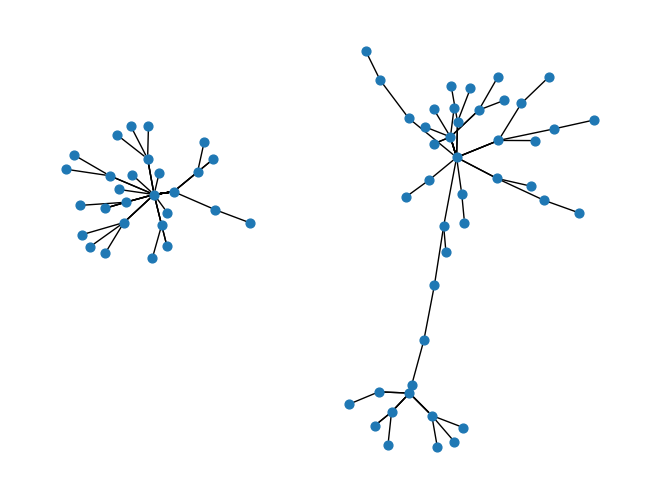

In [71]:
query = """
MATCH p = (a:MenuItem)-[:Links]->(b:MenuItem)
RETURN p;
"""


res = ku.execute(query)
G = res.get_as_networkx(directed=False)
nx.draw_spring(G, node_size=40)

In [72]:
from google.colab import output
output.enable_custom_widget_manager()
from yfiles_jupyter_graphs import GraphWidget

w = GraphWidget(graph=G)
w.set_sidebar(enabled=False)
display(w)

GraphWidget(layout=Layout(height='800px', width='100%'))

In [68]:
# Shortest Path
query = """
MATCH p = (a:MenuItem)-[:Links* SHORTEST 1..4]->(b:MenuItem)
WHERE b.name = 'Super steady'
RETURN p
"""

res = ku.execute(query)
res.get_as_df()["p"][0]

{'_nodes': [{'_id': {'offset': 0, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Apps',
   'description': '"Apps" is a menu providing access to your device\'s applications.  It allows you to manage installed apps, create folders to organize them, and potentially update or delete them.  You can also set default apps for various categories.  The "Apps" menu is a central hub for all your device\'s software.\n'},
  {'_id': {'offset': 1, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Samsung apps',
   'description': 'Samsung apps is a collection of pre-installed applications on Samsung devices.  These apps offer various functionalities, from managing contacts and emails to taking photos and browsing the web.  They include tools like Samsung Notes, Samsung Internet, and Samsung Pay.  These apps provide a convenient and integrated user experience within the Samsung ecosystem.\n'},
  {'_id': {'offset': 2, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Camera',
   'description': "The C

### Generate the Menue Item Descriptions

**Quick and Dirty approach**: Combine all possible answers and ask LLM to fix it!

In [ ]:
text_description_nodes = {}
for index, row in s10.iterrows():
  menu_items = row["section_path"].split(">")
  for item in menu_items:
    if item not in text_description_nodes.keys():
      text_description_nodes[item] = "";
      text_description_nodes[item] += row["answer"]
    else:
      text_description_nodes[item] += row["answer"]

In [ ]:
text_description_nodes.keys()

dict_keys(['Apps', 'Samsung apps', 'Camera', 'Camera settings', 'Settings', 'Lock screen and security', 'Location', 'Getting started', 'Start using your device', 'Always On Display', 'AOD themes', 'Screen lock types', 'Clock and information', 'Clock', 'Time zone converter', 'Connections', 'Mobile hotspot', 'Configure mobile hotspot settings', 'Samsung Notes', 'Notes menu', 'Gallery', 'Screenshot Settings', 'Flexible security', 'Fingerprint verification settings', 'Device maintenance', 'Storage', 'Device storage', 'Email', 'Customize your home screen', 'Home screen settings', 'Sounds and vibration', 'Notification sound', 'Smart Switch', 'Contacts', 'Add or remove group contacts', 'Using apps', 'Create and use folders', 'Display', 'Screen timeout', 'Credential storage', 'Palm swipe to capture a screenshot', 'Encrypt or decrypt SD card', 'Battery', 'App settings', 'Edit notes', 'Super steady', 'Face recognition management', 'Set a secure screen lock', 'Internet', 'Samsung Pay', 'Delete a 

In [ ]:
text_description_nodes["Apps"]

"Use the icons on the main camera screen and the settings menu to configure your camera’s settings.From  Camera, tap  Settings for the following options:Videos. Advanced recording options: Enhance your videos with advanced recording formats.High efficiency video: Record videos in HEVC format to save space. Other devices or sharing sites may not support playback of this format.HDR10+ video: Optimize videos by recording in HDR10+. Playback devices must support HDR10+ video.Set a time in a city on your World clock list to see what the local times would be in the other listed cities.From  Clock, tap World clock.Tap  More options > Time zone converter.Tap  Menu to choose a different city.To add a city to the list, tap  Add city.Swipe the hours, minutes, and period (AM or PM) on the clock to set a time. Local times for the other cities listed are automatically updated.To return the clock to the current time, tap Reset.You can view your notes by category. From  Samsung Notes, tap  Navigation 

In [ ]:
pd.DataFrame(text_description_nodes.items(), columns=["name","description"]).to_csv("node_with_description.csv")

### Design Prompt for generating descriptions of each menu

In [ ]:
def create_prompt(menu_item,text):
  return f"""
    You are a Content Writer, with responsibility to write User Manual:
    Here is an arbitary TEXT on one of the menu items -'{menu_item}'.
    ------TEXT------
    {text}
    -------TEXT-------
     Without any navigational information; Describe in 4 short sentences \"What is '{menu_item}'\"
  """

In [ ]:
test_prompt = create_prompt("Apps",text_description_nodes["Apps"])
test_prompt

'\n    You are a Content Writer, with responsibility to write User Manual:\n    Here is an arbitary TEXT on one of the menu items -\'Apps\'.\n    ------TEXT------\n    Use the icons on the main camera screen and the settings menu to configure your camera’s settings.From  Camera, tap  Settings for the following options:Videos. Advanced recording options: Enhance your videos with advanced recording formats.High efficiency video: Record videos in HEVC format to save space. Other devices or sharing sites may not support playback of this format.HDR10+ video: Optimize videos by recording in HDR10+. Playback devices must support HDR10+ video.Set a time in a city on your World clock list to see what the local times would be in the other listed cities.From  Clock, tap World clock.Tap  More options > Time zone converter.Tap  Menu to choose a different city.To add a city to the list, tap  Add city.Swipe the hours, minutes, and period (AM or PM) on the clock to set a time. Local times for the othe

In [ ]:
import google.generativeai as genai
from google.colab import userdata


genai.configure(api_key=userdata.get('GEMINI_API_KEY'))
model = genai.GenerativeModel("gemini-1.5-flash")
response = model.generate_content("Explain how AI works")
print(response.text)

AI works by mimicking human intelligence through various techniques, ultimately aiming to solve complex problems and make decisions.  There's no single "how" because AI encompasses a broad range of approaches, but here's a breakdown of key concepts:

**1. Data is King:**  AI systems learn from data. The more relevant and high-quality data they are trained on, the better their performance.  This data can be anything from images and text to sensor readings and financial transactions.

**2. Algorithms: The Recipe for Intelligence:** Algorithms are sets of rules and calculations that process data. These algorithms are the core of AI systems and dictate how they learn and make predictions.  Different types of AI use different algorithms.

**3. Machine Learning (ML): Learning from Data:** This is a subset of AI where systems learn patterns from data without explicit programming. Instead of being explicitly programmed with rules, they identify patterns and relationships within the data to mak

In [ ]:
list(text_description_nodes.keys())[21:31]

['Screenshot Settings',
 'Flexible security',
 'Fingerprint verification settings',
 'Device maintenance',
 'Storage',
 'Device storage',
 'Email',
 'Customize your home screen',
 'Home screen settings',
 'Sounds and vibration']

In [ ]:
model_responses = {}

In [ ]:
import time
for key in list(text_description_nodes.keys()):
  print(key)
  prompt = create_prompt(key,text_description_nodes[key])
  response = model.generate_content(prompt)
  model_responses[key] = response.text
  time.sleep(3)

In [ ]:
len(model_responses.keys())

72

In [ ]:
len(text_description_nodes.keys())

72

In [ ]:
nodes_doc = {
    "name":list(model_responses.keys()),
    "description":[model_responses[k] for k in model_responses.keys()]
}
nodes_doc

In [ ]:
nodes_df = pd.DataFrame(nodes_doc)
nodes_df.to_csv("nodes_doc.csv")
nodes_df.head()

,name,description
0,Apps,"""Apps"" is a menu providing access to your devi..."
1,Samsung apps,Samsung apps is a collection of pre-installed ...
2,Camera,The Camera feature lets you take photos and vi...
3,Camera settings,Camera settings allow you to customize your ca...
4,Settings,Settings is your device's central control pane...


### Create Graph where Nodes have their Descriptions

In [13]:
!unzip GraphRAG.zip

Archive:  GraphRAG.zip
replace edges.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: edges.csv               
  inflating: menu_items_dataset.csv  
  inflating: nodes_doc.csv           
  inflating: node_with_description.csv  
  inflating: s10_50_questions.csv    


In [69]:
import pandas as pd

nodes_df = pd.read_csv('nodes_doc.csv')
nodes_df = nodes_df.drop(nodes_df.columns[[0]], axis=1)
nodes_df

,name,description
0,Apps,"""Apps"" is a menu providing access to your devi..."
1,Samsung apps,Samsung apps is a collection of pre-installed ...
2,Camera,The Camera feature lets you take photos and vi...
3,Camera settings,Camera settings allow you to customize your ca...
4,Settings,Settings is your device's central control pane...
...,...,...
67,Maps,The Maps feature provides location-based servi...
68,Mobile continuity,Mobile Continuity lets you view and manage you...
69,Link to Windows,"Link to Windows connects your phone and PC, mi..."
70,View the Notification panel,The Notification panel displays all your recen...


In [16]:
!rm -rf /content/:memeory:

In [17]:
import kuzu

kuzudb = kuzu.Database(":memeory:")
ku = kuzu.Connection(kuzudb)

ku_query = """CREATE NODE TABLE MenuItem(name STRING, description STRING, PRIMARY KEY (name));"""
ku.execute(ku_query)
ku_query= """CREATE REL TABLE Links (FROM MenuItem TO MenuItem);"""
ku.execute(ku_query)
ku_query= """COPY MenuItem FROM nodes_df;"""
ku.execute(ku_query)
ku_query= """COPY Links FROM 'edges.csv';"""
ku_query= """
COPY LINKS FROM 'edges.csv' (header=true);
"""
ku.execute(ku_query)

In [73]:
# Shortest Path
query = """
MATCH p = (a:MenuItem)-[:Links* SHORTEST 1..4]->(b:MenuItem)
WHERE b.name = 'Super steady'
RETURN p
"""

res = ku.execute(query)
res.get_as_df()["p"][0]

{'_nodes': [{'_id': {'offset': 0, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Apps',
   'description': '"Apps" is a menu providing access to your device\'s applications.  It allows you to manage installed apps, create folders to organize them, and potentially update or delete them.  You can also set default apps for various categories.  The "Apps" menu is a central hub for all your device\'s software.\n'},
  {'_id': {'offset': 1, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Samsung apps',
   'description': 'Samsung apps is a collection of pre-installed applications on Samsung devices.  These apps offer various functionalities, from managing contacts and emails to taking photos and browsing the web.  They include tools like Samsung Notes, Samsung Internet, and Samsung Pay.  These apps provide a convenient and integrated user experience within the Samsung ecosystem.\n'},
  {'_id': {'offset': 2, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Camera',
   'description': "The C

In [ ]:
# 1. Auto generating test Case from User Journey,
  # 1.1 By Graph Traversal
  # 1.2 Persona Based
# 2. Auto generating test Case from an Support Ticket

# SLM

Decoder only model, as its an classification task

### Traditional RAG with Similarity Search Fails

In [19]:
! pip install chromadb chromadbx

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 kB 4.9 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 54.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.4/2.4 MB 81.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 94.9/94.9 kB 7.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 284.2/284.2 kB 18.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.4/76.4 kB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 69.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.6/101.6 kB 7.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.0/16.0 MB 62.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 55.9/55.9 kB 4.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.1/89.1 kB 6.3 MB/s eta 0:00:00


In [20]:
import chromadb
chroma_client = chromadb.Client()

In [21]:
archive_name = "nodes_menue_items"

In [22]:
collection = chroma_client.create_collection(name=archive_name)

In [23]:
# chroma_client.delete_collection(name=archive_name)

In [24]:
collection.upsert(
    ids=list(nodes_df["name"]),
    documents=list(nodes_df["description"])
)

/root/.cache/chroma/onnx_models/all-MiniLM-L6-v2/onnx.tar.gz: 100%|██████████| 79.3M/79.3M [00:02<00:00, 37.3MiB/s]


In [25]:
menu_items_dataset = s10[["question","section_path"]]
menu_items_dataset ["answer"]  = menu_items_dataset ["section_path"].apply(lambda x: x.split(">")[-1])
menu_items_dataset.to_csv("menu_items_dataset.csv")

<ipython-input-25-7cd92e56247e>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  menu_items_dataset ["answer"]  = menu_items_dataset ["section_path"].apply(lambda x: x.split(">")[-1])


In [26]:
len(menu_items_dataset)

50

In [27]:
queries = list(menu_items_dataset['question']) [0:5]
answers = list(menu_items_dataset['answer']) [0:5]
queries

['What are the advanced recording options available in my device camera?',
 'How can I turn on the GPS ?',
 'How to apply custom themes for AOD?',
 'How can I show notifications on always display?',
 'How can I use time zone converter?']

In [28]:
results = collection.query(
    query_texts= queries,
    n_results=1,
)
for m in results["ids"]:
  print(m)

['Camera']
['Location']
['AOD themes']
['View the Notification panel']
['Time zone converter']


In [29]:
answers

['Camera settings',
 'Location',
 'AOD themes',
 'Clock and information',
 'Time zone converter']

In [30]:
import os
import glob

path = os.getcwd()
extension = 'csv'
os.chdir(path)
csv_files = glob.glob('*.{}'.format(extension))
print(csv_files)

['menu_items_dataset.csv', 'nodes_doc.csv', 's10_50_questions.csv', 'node_with_description.csv', 'edges.csv']


In [ ]:
!zip GraphRAG.zip *.csv


zip error: Nothing to do! (GraphRAG.zip)


## Fine Tuning BERT


> To predict the Destination Node of the Graph



In [ ]:
!unzip GraphRAG.zip

Archive:  GraphRAG.zip
replace edges.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

In [ ]:
! rm -rf bert_usermanual_pytorch_cpu_quant_int8

## Final Node Prediction

In [31]:
label_map = {'0': 'Remove an account',
 '1': 'Time zone converter',
 '2': 'Notification sound',
 '3': 'Text-to-speech',
 '4': 'Samsung Pay',
 '5': 'Customize Widgets',
 '6': 'Delete a group',
 '7': 'Always On Display',
 '8': 'Manage notifications',
 '9': 'Credential storage',
 '10': 'Screen timeout',
 '11': 'Internet',
 '12': 'Permission manager',
 '13': 'Create and use folders',
 '14': 'Face recognition management',
 '15': 'Notifications',
 '16': 'Colors and clarity',
 '17': 'Device storage',
 '18': 'Battery',
 '19': 'Timer options',
 '20': 'Blue light filter',
 '21': 'Edit notes',
 '22': 'Super steady',
 '23': 'App settings',
 '24': 'Screenshot Settings',
 '25': 'Encrypt or decrypt SD card',
 '26': 'Maps',
 '27': 'Palm swipe to capture a screenshot',
 '28': 'Home screen settings',
 '29': 'Smart Switch',
 '30': 'Camera settings',
 '31': 'Set a secure screen lock',
 '32': 'Edit pictures',
 '33': 'Clock and information',
 '34': 'Add or remove group contacts',
 '35': 'View the Notification panel',
 '36': 'Location',
 '37': 'Configure mobile hotspot settings',
 '38': 'Email',
 '39': 'Notes menu',
 '40': 'AOD themes',
 '41': 'Fingerprint verification settings',
 '42': 'Link contacts',
 '43': 'NFC and payment'}

In [33]:
from google.colab import drive

# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:

! cp /content/drive/MyDrive/'Colab Notebooks'/'GenAI with LLM'/Models/bert_usermanual_pytorch.zip /content
! unzip bert_usermanual_pytorch.zip

Archive:  bert_usermanual_pytorch.zip
   creating: bert_usermanual_pytorch_cpu_quant_int8/
  inflating: bert_usermanual_pytorch_cpu_quant_int8/model.safetensors  
  inflating: bert_usermanual_pytorch_cpu_quant_int8/tokenizer_config.json  
  inflating: bert_usermanual_pytorch_cpu_quant_int8/config.json  
  inflating: bert_usermanual_pytorch_cpu_quant_int8/special_tokens_map.json  
  inflating: bert_usermanual_pytorch_cpu_quant_int8/vocab.txt  
   creating: bert_usermanual_pytorch_cpu_quant_int8/.ipynb_checkpoints/


In [35]:
import torch
from transformers import BertTokenizer, BertForSequenceClassification

# Load the trained model and tokenizer
model_path = './bert_usermanual_pytorch_cpu_quant_int8'  # Path where the trained model is saved
model = BertForSequenceClassification.from_pretrained(model_path)
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Function to make predictions
def predict_final_node(question):
    model.eval()  # Set the model to evaluation mode
    inputs = tokenizer(
        question,
        truncation=True,
        padding='max_length',
        max_length=128,
        return_tensors='pt'
    )
    with torch.no_grad():
        outputs = model(**inputs)
    predicted_label = torch.argmax(outputs.logits, dim=1).item()
    # print('label is ', predicted_label)

    # label_map= label_map_2

    final_node = label_map[str(predicted_label)]
    return final_node


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

In [74]:
# Example usage
questions = [
  'What are the advanced recording options available in my device camera?',
 'How can I turn on the GPS ?',
 'How to apply custom themes for AOD?',
 'How can I show notifications on always display?',
 'How can I use time zone converter?'
 ]

correct_answers = [
  'Camera settings',
  'Location',
  'AOD themes',
  'Clock and information',
  'Time zone converter'
 ]

for question in questions:
  print(question)
  print(predict_final_node(question))

What are the advanced recording options available in my device camera?
Camera settings
How can I turn on the GPS ?
Location
How to apply custom themes for AOD?
AOD themes
How can I show notifications on always display?
Clock and information
How can I use time zone converter?
Time zone converter


In [37]:
import kuzu
kuzudb = kuzu.Database(":memeory:")
ku = kuzu.Connection(kuzudb)

question =  'How to send an email?'
final_node =  predict_final_node(question)

# Shortest Path
query = f"""
MATCH p = (a:MenuItem)-[:Links* SHORTEST 1..4]->(b:MenuItem)
WHERE b.name = '{final_node}'
RETURN p
"""

res = ku.execute(query)
res.get_as_df()["p"][0]

{'_nodes': [{'_id': {'offset': 0, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Apps',
   'description': '"Apps" is a menu providing access to your device\'s applications.  It allows you to manage installed apps, create folders to organize them, and potentially update or delete them.  You can also set default apps for various categories.  The "Apps" menu is a central hub for all your device\'s software.\n'},
  {'_id': {'offset': 1, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Samsung apps',
   'description': 'Samsung apps is a collection of pre-installed applications on Samsung devices.  These apps offer various functionalities, from managing contacts and emails to taking photos and browsing the web.  They include tools like Samsung Notes, Samsung Internet, and Samsung Pay.  These apps provide a convenient and integrated user experience within the Samsung ecosystem.\n'},
  {'_id': {'offset': 27, 'table': 0},
   '_label': 'MenuItem',
   'name': 'Email',
   'description': 'The E

In [75]:

from google.colab import output
output.enable_custom_widget_manager()
from yfiles_jupyter_graphs import GraphWidget

res = ku.execute(query)
G = res.get_as_networkx(directed=False)
w = GraphWidget(graph=G)
w.set_sidebar(enabled=False)
display(w)


GraphWidget(layout=Layout(height='500px', width='100%'))

In [39]:
context = ""
step = 0
for node in res.get_as_df()["p"][0]["_nodes"]:
  menue_item = node["name"]
  # description = node["description"]
  context += f"""
  Step-{step+1}:{menue_item}
  """
  step += 1

print(context)


  Step-1:Apps
  
  Step-2:Samsung apps
  
  Step-3:Email
  


## Gemma

In [40]:
!wget https://huggingface.co/Mozilla/gemma-2-2b-it-llamafile/resolve/main/gemma-2-2b-it.Q6_K.llamafile

--2025-04-24 11:16:08--  https://huggingface.co/Mozilla/gemma-2-2b-it-llamafile/resolve/main/gemma-2-2b-it.Q6_K.llamafile
Resolving huggingface.co (huggingface.co)... 3.163.189.37, 3.163.189.90, 3.163.189.114, ...
Connecting to huggingface.co (huggingface.co)|3.163.189.37|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://cdn-lfs-us-1.hf.co/repos/ef/89/ef89a9740f6e1a30af8b23b439174cdcc7fcad0f17fe6ee52def426347f93063/ff29c1faf6a7b979129c4b7cff51e16e677f96b34023914ac3c02f71b62053bd?response-content-disposition=inline%3B+filename*%3DUTF-8%27%27gemma-2-2b-it.Q6_K.llamafile%3B+filename%3D%22gemma-2-2b-it.Q6_K.llamafile%22%3B&Expires=1745496968&Policy=eyJTdGF0ZW1lbnQiOlt7IkNvbmRpdGlvbiI6eyJEYXRlTGVzc1RoYW4iOnsiQVdTOkVwb2NoVGltZSI6MTc0NTQ5Njk2OH19LCJSZXNvdXJjZSI6Imh0dHBzOi8vY2RuLWxmcy11cy0xLmhmLmNvL3JlcG9zL2VmLzg5L2VmODlhOTc0MGY2ZTFhMzBhZjhiMjNiNDM5MTc0Y2RjYzdmY2FkMGYxN2ZlNmVlNTJkZWY0MjYzNDdmOTMwNjMvZmYyOWMxZmFmNmE3Yjk3OTEyOWM0YjdjZmY1MWUxNmU2NzdmOTZiMzQwMj

In [42]:
!chmod +x gemma-2-2b-it.Q6_K.llamafile

In [43]:
! nohup ./gemma-2-2b-it.Q6_K.llamafile --server  > gemma2b.llamafile.log &

nohup: redirecting stderr to stdout


In [ ]:
!./gemma-2-2b-it.Q6_K.llamafile --server

note: if you have an AMD or NVIDIA GPU then you need to pass -ngl 9999 to enable GPU offloading
{"build":1500,"commit":"a30b324","function":"server_cli","level":"INFO","line":2911,"msg":"build info","tid":"12265824","timestamp":1744884528}
{"function":"server_cli","level":"INFO","line":2918,"msg":"system info","n_threads":1,"n_threads_batch":1,"system_info":"AVX = 1 | AVX_VNNI = 0 | AVX2 = 1 | AVX512 = 0 | AVX512_VBMI = 0 | AVX512_VNNI = 0 | AVX512_BF16 = 0 | FMA = 1 | NEON = 0 | SVE = 0 | ARM_FMA = 0 | F16C = 1 | FP16_VA = 0 | WASM_SIMD = 0 | BLAS = 0 | SSE3 = 1 | SSSE3 = 1 | VSX = 0 | MATMUL_INT8 = 0 | LLAMAFILE = 1 | ","tid":"12265824","timestamp":1744884528,"total_threads":2}
llama_model_loader: loaded meta data with 36 key-value pairs and 288 tensors from gemma-2-2b-it.Q6_K.gguf (version GGUF V3 (latest))
llama_model_loader: Dumping metadata keys/values. Note: KV overrides do not apply in this output.
llama_model_loader: - kv   0:                       general.architecture str    

## Qwen

In [44]:
!pip install llama-cpp-python  'llama-cpp-python[server]'

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.3/67.3 MB 10.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Installing backend dependencies ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 45.5/45.5 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.4/44.4 kB 2.8 MB/s eta 0:00:00
  Created wheel for llama-cpp-python: filename=llama_cpp_python-0.3.8-cp311-cp311-linux_x86_64.whl size=5959629 sha256=125cf3ddcfaf0baa0ed1c4c72a99345f9aac67ac773f2027cac3b775863a4f71
  Stored in directory: /root/.cache/pip/wheels/c0/03/66/eb3810eafd55d921b2be32896d1f44313996982360663aa80b
Successfully built llama-cpp-python


In [45]:
!huggingface-cli download Qwen/Qwen2-1.5B-Instruct-GGUF qwen2-1_5b-instruct-q5_k_m.gguf --local-dir . --local-dir-use-symlinks False


/usr/local/lib/python3.11/dist-packages/huggingface_hub/commands/download.py:139: FutureWarning: Ignoring --local-dir-use-symlinks. Downloading to a local directory does not use symlinks anymore.
  warnings.warn(
qwen2-1_5b-instruct-q5_k_m.gguf: 100% 1.13G/1.13G [00:15<00:00, 72.6MB/s]
Download complete. Moving file to qwen2-1_5b-instruct-q5_k_m.gguf
qwen2-1_5b-instruct-q5_k_m.gguf


In [84]:
!fuser 9095/tcp

In [85]:
!nohup sudo python3 -m llama_cpp.server --model /content/qwen2-1_5b-instruct-q5_k_m.gguf --host 0.0.0.0 --port 9095 > qwen.gguf.log &

nohup: redirecting stderr to stdout


# Device Helper App

In [53]:
def graph_rag(user_query):
  # Find the destination Node


  # Find the path
  final_node =  predict_final_node(question)

  # Shortest Path
  query = f"""
  MATCH p = (a:MenuItem)-[:Links* SHORTEST 1..4]->(b:MenuItem)
  WHERE b.name = '{final_node}'
  RETURN p
  """

  res = ku.execute(query)
  node_list = res.get_as_df()["p"][0]
  # Summerise path
  # Add the Path to Context, and create Prompt
  context = ""
  step = 0
  for node in res.get_as_df()["p"][0]["_nodes"]:
    menue_item = node["name"]
    description = node["description"]
    text = f"Step-{step+1}:{menue_item}; {description} \n"
    context+= text
    step += 1
  return context


In [79]:
question = "How to send an Email?"
graph_rag(question)

'Step-1:Apps; "Apps" is a menu providing access to your device\'s applications.  It allows you to manage installed apps, create folders to organize them, and potentially update or delete them.  You can also set default apps for various categories.  The "Apps" menu is a central hub for all your device\'s software.\n \nStep-2:Samsung apps; Samsung apps is a collection of pre-installed applications on Samsung devices.  These apps offer various functionalities, from managing contacts and emails to taking photos and browsing the web.  They include tools like Samsung Notes, Samsung Internet, and Samsung Pay.  These apps provide a convenient and integrated user experience within the Samsung ecosystem.\n \nStep-3:Email; The Email app lets you access and manage all your email accounts in one place.  It provides a unified inbox for easy viewing and organization of your messages.  Adding new accounts is simple and straightforward.  This app simplifies email management by consolidating all your in

In [80]:
from openai import OpenAI

def graph_rag_slm(user_query,llm_url):
  question = ""


  content = graph_rag(user_query)

  messages = []
  messages.append({"role": "system", "content": "You are a helpful assistant to help the user with questions about the Android Device by giving step by step information based on user provided text"})
  messages.append({"role": "user", "content": f"Answer the question: '{user_query}', using the given text, Dont use Serial number for steps"})
  messages.append({"role":"user","content":content})
  client = OpenAI(base_url=llm_url, api_key="sk-xxx")
  response = client.chat.completions.create(
      model="xxxxx-x_xx-xxxxxx",
      messages=messages,
  )
  return response.choices[0].message.content


In [88]:
gemini2b_response = graph_rag_slm("How to send an Email?","http://localhost:8081/v1")

In [89]:
# render markdown variable
from IPython.display import display, Markdown
display(Markdown(gemini2b_response))


Here's how to send an email on your Android device:

**1. Find the Email App:**

* Look for the "Email" app on your home screen or in the "Apps" menu. It's usually a recognizable icon with an envelope.

**2. Open the Email App:**

* Tap on the "Email" app icon to open it.

**3. Add an Email Account:**

* If you haven't already, you'll need to add your email account.  
    * You'll likely be prompted to enter your email address and password. 
    * Follow the on-screen instructions to complete the setup.

**4. Compose a New Email:**

* Once your account is set up, you'll see a screen where you can compose a new email.
* You can add a recipient's email address, subject line, and message body.

**5. Send the Email:**

* Once you've written your email, tap the "Send" button. 


That's it! You've successfully sent an email. 
<end_of_turn>

In [86]:
qwen_response = graph_rag_slm("How to turn on GPS?","http://localhost:9095/v1")

In [87]:
# render markdown variable
from IPython.display import display, Markdown
display(Markdown(qwen_response))


In order to turn on GPS, you should follow these steps:

Step-1: Apps - The "Apps" menu is a central hub for all your device's software. You can use this menu to manage installed apps, create folders to organize them, and potentially update or delete them.

Step-2: Samsung Apps - These pre-installed applications offer various functionalities such as managing contacts and emails, taking photos, and browsing the web. They include tools like Samsung Notes, Samsung Internet, and Samsung Pay, providing an integrated user experience within the Samsung ecosystem.

Step-3: Email - The "Email" app allows you to access and manage all your email accounts in one place. It provides a unified inbox for easy viewing and organization of messages, making it simple and straightforward to add new accounts.

If you are referring to the GPS functionality on your phone, you can try these steps:

Step-1: Apps - In the "Apps" menu, navigate to the "Location" or "Maps" option. This will give you a list of various location services, including GPS tracking. Select one of those options and make sure it's turned on.

For instance, if your phone has GPS enabled by default, this step may be redundant. If not, check for an application such as Maps or Google Maps that offers GPS functionality and ensure it's enabled.

Step-2: Samsung Apps - Find the "GPS" option within Samsung apps, which is often found in the device settings menu. This will usually give you options to turn on, off or customize the GPS service.

Step-3: Email - In the "Email" app, navigate through your account management tools if necessary (e.g., Gmail) to ensure that the 'Location' option is activated and properly enabled for your email account.

If all else fails, refer to the device manufacturer's documentation or consult online forums for specific device models. They might have detailed instructions on how to set up GPS functionality.